In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce
from helpers import *
import numpy as np
from scipy.optimize import curve_fit
import tifffile
from sklearn.linear_model import LinearRegression


### DANIEL BLOCK IMAGES

In [ ]:


# Load the TIFF file
file_path = '/Users/mattice/Desktop/MLProject_BrowianMotion/ml-project-2-big-burger/real-data/blocks_64x64x16_70_01/block-001-6.658-0.057-456.tif'
images = tifffile.imread(file_path)

# Define a 2D Gaussian model
def two_d_gaussian(coords, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = coords
    xo = float(x0)
    yo = float(y0)
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
    c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
    g = offset + amplitude * np.exp(- (a * ((x - xo)**2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo)**2)))
    return g.ravel()

# Fit a 2D Gaussian to an image
def fit_gaussian_to_image(img):
    y_size, x_size = img.shape
    x = np.linspace(0, x_size - 1, x_size)
    y = np.linspace(0, y_size - 1, y_size)
    x, y = np.meshgrid(x, y)

    amplitude_guess = np.max(img)
    y0_guess, x0_guess = np.unravel_index(np.argmax(img), img.shape)
    sigma_x_guess = sigma_y_guess = 2.0
    theta_guess = 0
    offset_guess = np.median(img)

    initial_guess = (amplitude_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess, theta_guess, offset_guess)
    popt, _ = curve_fit(two_d_gaussian, (x, y), img.ravel(), p0=initial_guess, maxfev=2000)
    x0, y0 = popt[1], popt[2]
    return x0, y0

# Extract centroids from the images
def  get_centroids_1(images):
    centroids = []
    for img in images:
        x0, y0 = fit_gaussian_to_image(img)
        centroids.append((x0, y0))
    return np.array(centroids)

# Compute Mean Squared Displacement (MSD)
def compute_msd(positions, dt):
    N = positions.shape[0]
    msd = []
    time_lags = []
    for lag in range(1, N):
        diffs = positions[lag:] - positions[:-lag]
        squared_diffs = np.sum(diffs**2, axis=1)
        msd.append(np.mean(squared_diffs))
        time_lags.append(lag * dt)
    return np.array(time_lags), np.array(msd)

# Fit diffusion coefficient from MSD
def fit_diffusion_coefficient(time_lags, msd):
    model = LinearRegression(fit_intercept=False)
    model.fit(time_lags.reshape(-1, 1), msd)  # Fit model to data
    slope = model.coef_[0]
    D_estimated = slope / 4
    return D_estimated



# Parameters
dt = 0.1  # seconds per frame

# Compute centroids, MSD, and diffusion coefficient
centroids =  get_centroids_1(images)
time_lags, msd = compute_msd(centroids, dt)
D_pixel_units = fit_diffusion_coefficient(time_lags, msd)

# Output results
print("Centroids (pixels):", centroids)
print("Time Lags (s):", time_lags)
print("MSD (pixels^2):", msd)
print("Diffusion Coefficient D (pixels^2/s):", D_pixel_units)


In [ ]:
import matplotlib.pyplot as plt

# Function to plot images with centroids
def plot_images_with_centroids(images, centroids):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray', origin='lower')
        ax.scatter(centroids[i, 0], centroids[i, 1], color='red', s=10, label='Centroid')  # Reduced point size
        ax.set_title(f"Frame {i + 1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_images_with_centroids(images, centroids)


In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import center_of_mass
import tifffile

# Load the TIFF file
file_path = '/Users/mattice/Desktop/MLProject_BrowianMotion/ml-project-2-big-burger/real-data/blocks_64x64x16_70_01/block-001-6.658-0.057-456.tif'
images = tifffile.imread(file_path)



# Fit diffusion coefficient from MSD
def fit_diffusion_coefficient(time_lags, msd):
    def linear(t, a, b):
        return a * t + b
    popt, _ = curve_fit(linear, time_lags, msd, p0=(1, 0))
    D = popt[0] / 4.0
    return D

# Parameters
dt = 0.1  # seconds per frame

# Compute centroids, MSD, and diffusion coefficient
centroids = get_centroids_1(images)
time_lags, msd = compute_msd(centroids, dt)
D_pixel_units = fit_diffusion_coefficient(time_lags, msd)

# Output results
print("Centroids (pixels):", centroids)
print("Time Lags (s):", time_lags)
print("MSD (pixels^2):", msd)
print("Diffusion Coefficient D (pixels^2/s):", D_pixel_units)


In [ ]:
import matplotlib.pyplot as plt

# Function to plot images with centroids
def plot_images_with_centroids(images, centroids):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray', origin='lower')
        ax.scatter(centroids[i, 0], centroids[i, 1], color='red', s=10, label='Centroid')  # Reduced point size
        ax.set_title(f"Frame {i + 1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_images_with_centroids(images, centroids)


###  IMAGES GENEREES

In [ ]:



# Fit the diffusion coefficient from MSD
def fit_diffusion_coefficient(time_lags, msd):
    model = LinearRegression(fit_intercept=False)
    model.fit(time_lags.reshape(-1, 1), msd)
    slope = model.coef_[0]
    D_estimated = slope / 4
    return D_estimated

### Parameters for the simulation and image generation
nframes = 16    # number of frames
nposframe = 10
dt = 0.01        # seconds between frames
DGen = 20000     # diffusion coefficient in nm^2/s
npixel = 64
pixelsize = 100  # nm per pixel
fwhm_psf = 200   # nm
factor_hr = 5
flux = 100
poisson_noise = 100
gaussian_noise = 10
background = 100
normalizeValue = 1000

# Generate images and ground truth data
images_arr, estimatedDs = generateImagesAndEstimateDMAXD(
    1, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize, flux, background, 
    poisson_noise, gaussian_noise, normalizeValue
)
images = images_arr[0]

# Display the first 16 images
global_min_gen = np.min(images)
global_max_gen = np.max(images)
num_images = min(16, len(images))
rows, cols = 2, 8
plt.figure(figsize=(20, 8))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i], cmap="gray", vmin=global_min_gen, vmax=global_max_gen)
    plt.title(f"Image {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Compute centroids, MSD, and diffusion coefficient
centroids = get_centroids_1(images)   # shape: (nframes, 2)
time_lags, msd = compute_msd(centroids, dt)
D_pixel_units = fit_diffusion_coefficient(time_lags, msd)

# Convert D from pixels^2/s to nm^2/s if desired
# Since 1 pixel = pixelsize nm, D_nm = D_pixel_units * (pixelsize^2)
D_nm_s = D_pixel_units * (pixelsize**2)

# Print results
print("Centroids (pixels):", centroids)
print("Time Lags (s):", time_lags)
print("MSD (pixels^2):", msd)

print("Diffusion Coefficient D (pixels^2/s):", D_pixel_units)
print("Diffusion Coefficient D (nm^2/s):", D_nm_s)
print('AAAA',estimatedDs/1000)

In [ ]:
def plot_images_with_centroids(images, centroids):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray', origin='lower')
        ax.scatter(centroids[i, 0], centroids[i, 1], color='red', s=10, label='Centroid')  # Reduced point size
        ax.set_title(f"Frame {i + 1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_images_with_centroids(images, centroids)

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Define a 2D Gaussian model
def two_d_gaussian(coords, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = coords
    xo = float(x0)
    yo = float(y0)
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
    c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
    g = offset + amplitude * np.exp(- (a * ((x - xo)**2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo)**2)))
    return g.ravel()

# Fit a 2D Gaussian to an image
def fit_gaussian_to_image(img, pixelsize, fwhm_psf):
    y_size, x_size = img.shape
    x = np.linspace(0, x_size - 1, x_size)
    y = np.linspace(0, y_size - 1, y_size)
    x, y = np.meshgrid(x, y)

    amplitude_guess = np.max(img)
    y0_guess, x0_guess = np.unravel_index(np.argmax(img), img.shape)
    sigma_x_guess = sigma_y_guess = fwhm_psf / pixelsize / 2.355  # Convert PSF FWHM to std. dev
    theta_guess = 0
    offset_guess = np.min(img)

    initial_guess = (amplitude_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess, theta_guess, offset_guess)
    try:
        popt, _ = curve_fit(two_d_gaussian, (x, y), img.ravel(), p0=initial_guess, maxfev=2000)
        x0, y0 = popt[1], popt[2]
    except RuntimeError:
        print("Gaussian fit failed for this frame.")
        x0, y0 = np.unravel_index(np.argmax(img), img.shape)  # Fallback: Max intensity

    return x0, y0, popt if 'popt' in locals() else None

# Visualize the Gaussian fit
def visualize_fit(img, popt):
    y_size, x_size = img.shape
    x = np.linspace(0, x_size - 1, x_size)
    y = np.linspace(0, y_size - 1, y_size)
    x, y = np.meshgrid(x, y)
    fit = two_d_gaussian((x, y), *popt).reshape(y_size, x_size)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img, cmap="gray")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title("Gaussian Fit")
    plt.imshow(fit, cmap="gray")
    plt.colorbar()
    plt.show()

# Extract centroids from the images
def get_centroids(images, pixelsize, fwhm_psf):
    centroids = []
    for img in images:
        img_smoothed = gaussian_filter(img, sigma=1)  # Apply noise reduction
        x0, y0, popt = fit_gaussian_to_image(img_smoothed, pixelsize, fwhm_psf)
        centroids.append((x0, y0))

        if popt is not None:
            visualize_fit(img_smoothed, popt)  # Visualize the fit for debugging

    return np.array(centroids)

# Compute Mean Squared Displacement (MSD)
def compute_msd(positions, dt):
    N = positions.shape[0]
    msd = []
    time_lags = []
    for lag in range(1, N):
        diffs = positions[lag:] - positions[:N-lag]
        squared_diffs = np.sum(diffs**2, axis=1)
        msd.append(np.mean(squared_diffs))
        time_lags.append(lag * dt)
    return np.array(time_lags), np.array(msd)

# Fit diffusion coefficient from MSD
def fit_diffusion_coefficient(time_lags, msd):
    model = LinearRegression(fit_intercept=False)
    model.fit(time_lags.reshape(-1, 1), msd)  # Fit model to data
    slope = model.coef_[0]
    D_estimated = slope / 4
    return D_estimated

### Parameters for simulation and image generation
nframes = 16    # Number of frames
nposframe = 10
dt = 0.01        # Seconds between frames
DGen = 10000     # Diffusion coefficient in nm^2/s
npixel = 64
pixelsize = 100  # nm per pixel
fwhm_psf = 200   # nm
factor_hr = 5
flux = 100
poisson_noise = 100
gaussian_noise = 10
background = 100
normalizeValue = 1000
n_val_im = 50
# Generate dummy images (replace this with your actual image generation function)
val_trajs = np.load('/Users/mattice/Desktop/MLProject_BrowianMotion/ml-project-2-big-burger/validation_trajectories.npy')
val_images, valDs = generateImagesAndEstimateDFromTrajs(val_trajs,n_val_im, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)

images = val_images[4]

# Compute centroids, MSD, and diffusion coefficient
centroids = get_centroids(images, pixelsize, fwhm_psf)   # Shape: (nframes, 2)
time_lags, msd = compute_msd(centroids, dt)
D_pixel_units = fit_diffusion_coefficient(time_lags, msd)

# Convert D from pixels^2/s to nm^2/s
D_nm_s = D_pixel_units * (pixelsize**2)

# Plot MSD
plt.plot(time_lags, msd, 'o-')
plt.xlabel("Time Lag (s)")
plt.ylabel("MSD (pixels^2)")
plt.title("Mean Squared Displacement")
plt.show()

# Print results
print("Centroids (pixels):", centroids)
print("Time Lags (s):", time_lags)
print("MSD (pixels^2):", msd)
print("Diffusion Coefficient D (pixels^2/s):", D_pixel_units)
print("Diffusion Coefficient D (nm^2/s):", D_nm_s)
print("Diffusion COefficient D from our estimation",valDs[4]/1000)

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Define a 2D Gaussian model
def two_d_gaussian(coords, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = coords
    xo = float(x0)
    yo = float(y0)
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
    c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
    g = offset + amplitude * np.exp(- (a * ((x - xo)**2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo)**2)))
    return g.ravel()

# Fit a 2D Gaussian to an image
def fit_gaussian_to_image(img, pixelsize, fwhm_psf):
    y_size, x_size = img.shape
    x = np.linspace(0, x_size - 1, x_size)
    y = np.linspace(0, y_size - 1, y_size)
    x, y = np.meshgrid(x, y)

    amplitude_guess = np.max(img)
    y0_guess, x0_guess = np.unravel_index(np.argmax(img), img.shape)
    sigma_x_guess = sigma_y_guess = fwhm_psf / pixelsize / 2.355  # Convert PSF FWHM to std. dev
    theta_guess = 0
    offset_guess = np.min(img)

    initial_guess = (amplitude_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess, theta_guess, offset_guess)
    try:
        popt, _ = curve_fit(two_d_gaussian, (x, y), img.ravel(), p0=initial_guess, maxfev=2000)
        x0, y0 = popt[1], popt[2]
    except RuntimeError:
        print("Gaussian fit failed for this frame.")
        x0, y0 = np.unravel_index(np.argmax(img), img.shape)  # Fallback: Max intensity

    return x0, y0, popt if 'popt' in locals() else None

# Extract centroids from the images
def get_centroids(images, pixelsize, fwhm_psf):
    centroids = []
    for img in images:
        img_smoothed = gaussian_filter(img, sigma=1)  # Apply noise reduction
        x0, y0, popt = fit_gaussian_to_image(img_smoothed, pixelsize, fwhm_psf)
        centroids.append((x0, y0))
    return np.array(centroids)

# Compute Mean Squared Displacement (MSD)
def compute_msd(positions, dt):
    N = positions.shape[0]
    msd = []
    time_lags = []
    for lag in range(1, N):
        diffs = positions[lag:] - positions[:N-lag]
        squared_diffs = np.sum(diffs**2, axis=1)
        msd.append(np.mean(squared_diffs))
        time_lags.append(lag * dt)
    return np.array(time_lags), np.array(msd)

# Fit diffusion coefficient from MSD
def fit_diffusion_coefficient(time_lags, msd):
    model = LinearRegression(fit_intercept=False)
    model.fit(time_lags.reshape(-1, 1), msd)  # Fit model to data
    slope = model.coef_[0]
    D_estimated = slope / 4
    return D_estimated

# Iterate over all validation images and their corresponding diffusion coefficients
for idx, (images, true_D) in enumerate(zip(val_images, valDs)):
    print(f"Processing trajectory set {idx + 1}")
    centroids = get_centroids(images, pixelsize, fwhm_psf)
    time_lags, msd = compute_msd(centroids, dt)
    D_pixel_units = fit_diffusion_coefficient(time_lags, msd)
    D_nm_s = D_pixel_units * (pixelsize**2)




    print("Diffusion Coefficient D (pixels^2/s):", D_pixel_units)
    print("Diffusion Coefficient D (nm^2/s):", D_nm_s)
    print("True Diffusion Coefficient D (nm^2/s):", true_D / 1000)

Processing trajectory set 1
Diffusion Coefficient D (pixels^2/s): 33.80762477622652
Diffusion Coefficient D (nm^2/s): 338076.2477622652
True Diffusion Coefficient D (nm^2/s): 0.9370403369150057
Processing trajectory set 2
Diffusion Coefficient D (pixels^2/s): 69.74532833431932
Diffusion Coefficient D (nm^2/s): 697453.2833431932
True Diffusion Coefficient D (nm^2/s): 1.9546486538046934
Processing trajectory set 3
Diffusion Coefficient D (pixels^2/s): 117.61340219966398
Diffusion Coefficient D (nm^2/s): 1176134.02199664
True Diffusion Coefficient D (nm^2/s): 2.911942059622747
Processing trajectory set 4
Diffusion Coefficient D (pixels^2/s): 129.6749530202468
Diffusion Coefficient D (nm^2/s): 1296749.530202468
True Diffusion Coefficient D (nm^2/s): 3.5336904046896622
Processing trajectory set 5
Diffusion Coefficient D (pixels^2/s): 164.471819304355
Diffusion Coefficient D (nm^2/s): 1644718.19304355
True Diffusion Coefficient D (nm^2/s): 4.5225523190031405
Processing trajectory set 6
Diffu

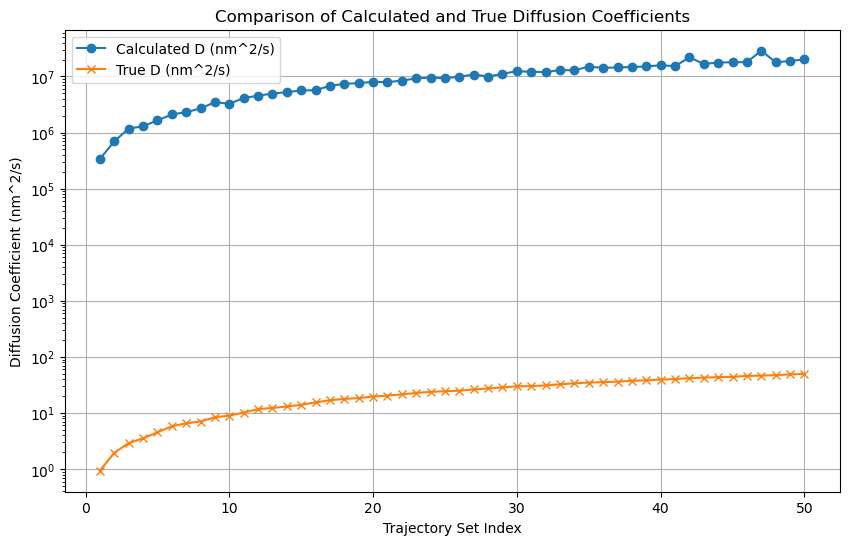

In [59]:
import matplotlib.pyplot as plt

# Lists to store results
calculated_D_nm_s = []
true_D_nm_s = []
indices = []

# Process each trajectory set and collect results
for idx, (images, true_D) in enumerate(zip(val_images, valDs)):
    print(f"Processing trajectory set {idx + 1}")
    
    centroids = get_centroids(images, pixelsize, fwhm_psf)
    time_lags, msd = compute_msd(centroids, dt)
    D_pixel_units = fit_diffusion_coefficient(time_lags, msd)
    D_nm_s = D_pixel_units * (pixelsize**2)
    
    # Store results
    calculated_D_nm_s.append(D_nm_s)
    true_D_nm_s.append(true_D / 1000)
    indices.append(idx + 1)
    
    # Print results
    print("Diffusion Coefficient D (pixels^2/s):", D_pixel_units)
    print("Diffusion Coefficient D (nm^2/s):", D_nm_s)
    print("True Diffusion Coefficient D (nm^2/s):", true_D / 1000)

# Plot results
plt.figure(figsize=(10, 6))

plt.plot(indices, calculated_D_nm_s, label="Calculated D (nm^2/s)", marker='o')
plt.plot(indices, true_D_nm_s, label="True D (nm^2/s)", marker='x')

plt.xlabel("Trajectory Set Index")
plt.ylabel("Diffusion Coefficient (nm^2/s)")
plt.yscale("log")
plt.title("Comparison of Calculated and True Diffusion Coefficients")
plt.legend()
plt.grid(True)

plt.show()


In [60]:

# Compute the ratio for each trajectory set
ratios = [calc / true for calc, true in zip(calculated_D_nm_s, true_D_nm_s)]

# Check for consistency
for i, ratio in enumerate(ratios):
    print(f"Trajectory set {i + 1}: Ratio = {ratio}")

# Summary statistics
mean_ratio = sum(ratios) / len(ratios)
print(f"Mean Ratio: {mean_ratio}")
print(f"Standard Deviation of Ratios: {sum((r - mean_ratio) ** 2 for r in ratios) ** 0.5 / len(ratios)}")


Trajectory set 1: Ratio = 360791.5630135039
Trajectory set 2: Ratio = 356817.7237303549
Trajectory set 3: Ratio = 403900.21432947484
Trajectory set 4: Ratio = 366967.49904335546
Trajectory set 5: Ratio = 363670.3518348856
Trajectory set 6: Ratio = 361781.8100029491
Trajectory set 7: Ratio = 352445.2268254658
Trajectory set 8: Ratio = 380911.81889088737
Trajectory set 9: Ratio = 414745.91649494594
Trajectory set 10: Ratio = 362284.7102862569
Trajectory set 11: Ratio = 402939.1182064245
Trajectory set 12: Ratio = 387887.84865388274
Trajectory set 13: Ratio = 400651.77764454565
Trajectory set 14: Ratio = 401928.58099266497
Trajectory set 15: Ratio = 401120.61236751196
Trajectory set 16: Ratio = 367502.61437768064
Trajectory set 17: Ratio = 401960.42120726977
Trajectory set 18: Ratio = 413725.0755591408
Trajectory set 19: Ratio = 410295.76139319007
Trajectory set 20: Ratio = 408119.5725232478
Trajectory set 21: Ratio = 385891.79051551584
Trajectory set 22: Ratio = 393986.65429299575
Trajec